## Deep learning labelling

This notebook can be used to set up an image set for training a neural network for a segmentation task.  

In [23]:
import os.path
from skimage.io import imread
from tnia.plotting.projections import show_xyz_max
import numpy as np
from lamprogen.io.io_helper import get_well_and_channel_names
from stardist.models import StarDist2D, StarDist3D

In [29]:
import inspect

inspect.getfile(StarDist2D)

'/Users/marcchiu/anaconda3/envs/lamprogen_decon_stardist/lib/python3.10/site-packages/stardist/models/model2d.py'

## Load previous model (optional)

If you have a previous model, you can load it, generate segmentation results then use these as the starting point for labels, then use the drawing tools to correct mistakes.  Otherwise you will start from an empty image when generating labels. 

In [2]:
# set modeldir and model to None to start labelling without previous model
# otherwise load a previously trained model, run it, and refine the labels

modeldir = None
model = None
#modeldir='C:\\Users\\bnort\\work\\lamprogen\\models'
#model = StarDist2D(None, name='lamprogen', basedir=modeldir)

modeldir = f'/Users/marcchiu/lamprogen-python/notebooks/deep learning/models'
name = 'stardist_model_96ray_combined'
model = StarDist3D(None, name=name,basedir=modeldir)


modeldir = f'/Users/marcchiu/lamprogen-python/notebooks/deep learning/models'
name = 'lamprogen-stardist-trained'
model = StarDist2D(None, name=name,basedir=modeldir)

2023-07-24 14:09:41.998000: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading network weights from 'weights_best.h5'.
Couldn't load thresholds from 'thresholds.json', using default values. (Call 'optimize_thresholds' to change that.)
Using default values: prob_thresh=0.5, nms_thresh=0.4.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.571909, nms_thresh=0.3.


## Load 3D input image

There are two ways to load data

### Load raw PCR plate data 

Define the path to the image data, and define the 'split' marker.  The split marker is the string that precedes the well and channel markers in the image names.  For example for the directory ```C:\Users\Administrator\data\220427 postPCR plate 12 duplex_Plate_256``` the split marker is ```duplex_``` as shown below.  

```
220427 postPCR plate 13 duplex_B03_w1.tif
```

For other datasets the split marker may be different (for example there are cases where it is ```bsa2_``` or ```bath_```)

We then call a utility to get the wells and channels for the dataset.  If no wells or channel names are shown there could be an error in the path name. 

Then we define well and channel to label.  It is recommended to label a few patches (ROIs) for a few different wells.

Then Load load the data, show max projections for each axis and then open Napari and view the data in the 3D Viewer.  This step is done to verify the data is as expected.  In Napari you can scroll through each slice of data and decide which z position(s) are in focus and should be labeled.

### Load .tif files (for example load the deconvolved data)

channels are
w1 w2 

wells are
D01 D02 D03 D04 D05 D06 D07 D08 D09 D10 D11 D12 

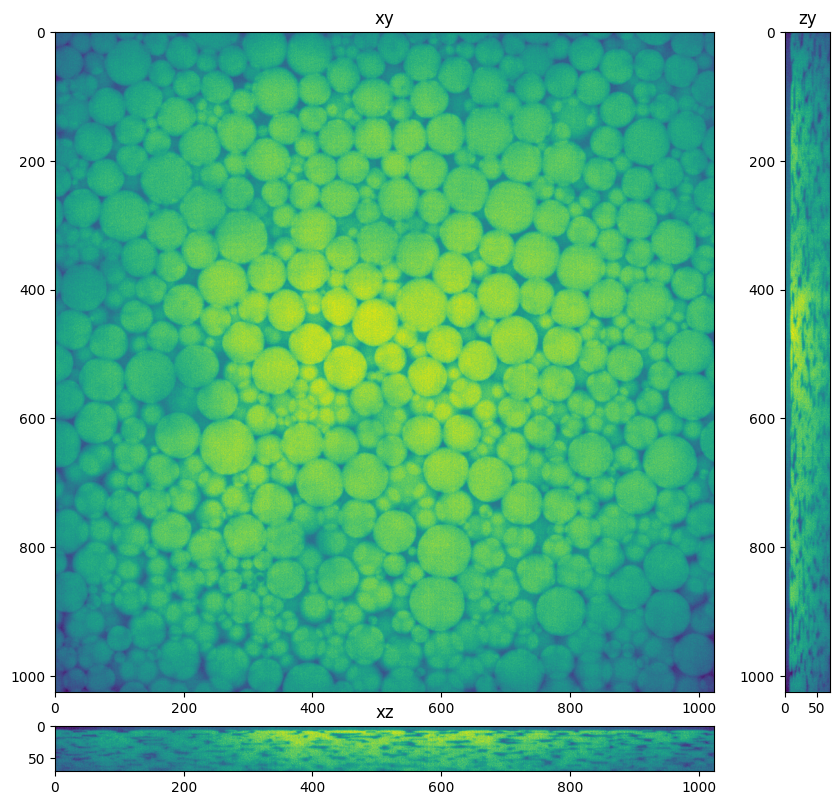

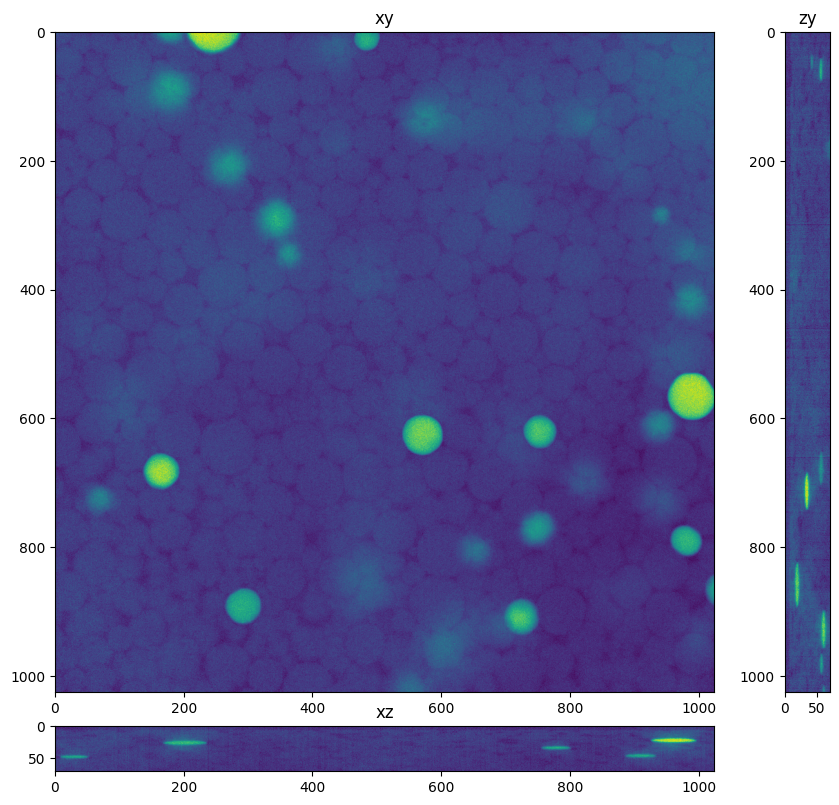

In [5]:
path_ = f'/Users/marcchiu/lamprogen-python/notebooks/deep learning/Annotations/230413 GLA HEX grad post v2_Plate_1081'
splitter = 'v2_'
format = 'raw_plate' 
# define the well and wavelength to be labelled
well='D08'
seg_wavelength=2
int_wavelength=1

#path_=r"C:\Users\bnort\work\lamprogen\images\Dec 2022\221202 M3 - 5 MJ1 post_Plate_797\TimePoint_1\deconvolution_psfmodels_attenuation_cf1.3_d100\A01_w1_im_seg.TIF"
#path_int=r"C:\Users\bnort\work\lamprogen\images\Dec 2022\221202 M3 - 5 MJ1 post_Plate_797\TimePoint_1\deconvolution_psfmodels_attenuation_cf1.3_d100\A01_w1_im_int.TIF"
#format = 'tif'
# define the well and wavelength to be labelled
#well='A01'
#wavelength=1

if format == 'raw_plate':
    # define timepoint, well string, and wavelength number
    timepoint=1
    zStep=1

    wells, channels = get_well_and_channel_names(path_,timepoint,zStep,splitter)

    print('channels are')
    for c in channels:
        print(c,end=' ')

    print()
    print()
    print('wells are')
    for w in wells:
        print(w,end=' ')


    from lamprogen.io.io_helper import open_PCR_dir

    im = open_PCR_dir(path_, timepoint, 1, well, seg_wavelength)
    im_int = open_PCR_dir(path_, timepoint, 2, well, int_wavelength)

elif format == 'tif':
    im = imread(path_)
    im_int = imread(path_int)

slice_to_view = 10
from tnia.plotting.projections import show_xyz_slice, show_xyz_max
fig = show_xyz_slice(im, 512, 512, slice_to_view,1,1)
fig = show_xyz_slice(im_int, 512, 512, slice_to_view,1,1)

## Look at current labels in 2d

If you have loaded in a previous model and are refining, take a look at the current model performance in 2dd

In [6]:
isinstance(model, StarDist3D), isinstance(model, StarDist2D), isinstance(None, StarDist2D)

(False, True, False)

1/1 [==============================] - 0s 427ms/step


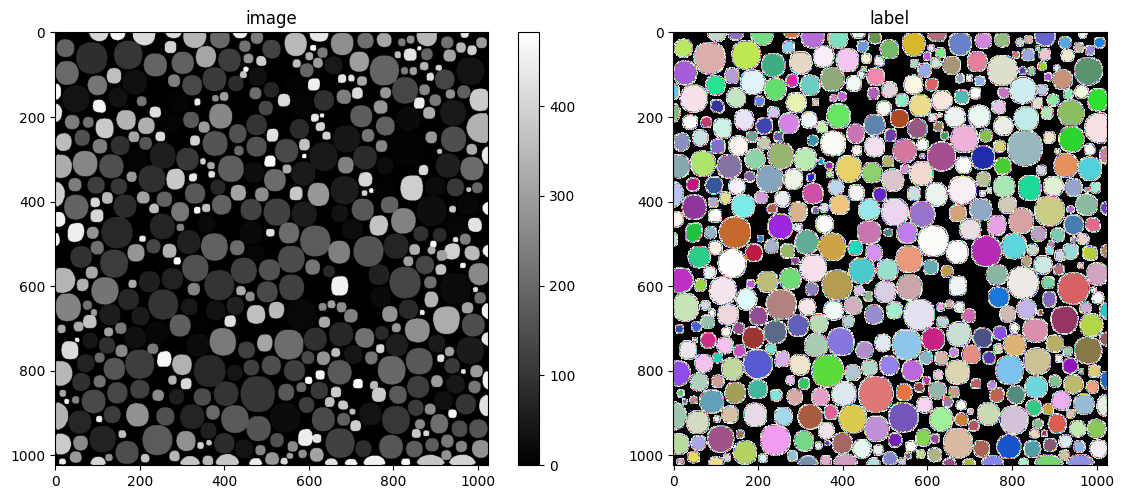

In [10]:
from lamprogen.recipes.dl import stardist_pretrained_fluo
from skimage.transform import resize

slice_to_process=20

from tnia.deeplearning.dl_helper import plot_img_label

if isinstance(model, StarDist2D):
    im_to_process=im[slice_to_process]
    label_image, normalized=stardist_pretrained_fluo(im_to_process, model)
    fig=plot_img_label(normalized, label_image)
elif isinstance(model, StarDist3D):
    im_ds = resize(im, (im.shape[0],im.shape[1]//2,im.shape[2]//2), anti_aliasing=True)
    im_ds  = (im_ds.astype('float32')-im_ds.min()) / (im_ds.max() - im_ds.min())

    labels, details = model.predict_instances(im_ds, prob_thresh=0.3, nms_thresh=0.3)
    labels = resize(labels, im.shape, order=0, preserve_range=True, anti_aliasing=False)
    labeled_3D = labels.astype('uint16')
    fig = show_xyz_slice(labels, 512, 512, slice_to_view,1,1)
    
    

## Generate starting data with current model in 3D

In this step we apply the model to every plane in 3D

In [40]:
np.issubdtype(type(im), np.uint)

False

In [36]:
from lamprogen.recipes.dl import stardist_2d_slicewise

if isinstance(model, StarDist2D):
    print('2d model: segmenting slilce by slice')
    labeled_3D = stardist_2d_slicewise(im, model)
elif isinstance(model, StarDist3D):
    print('3d model')
else:
    print('No model was loaded')

2d model: segmenting slilce by slice
1/1 [==============================] - 1s 537ms/step


## Convert label image to binary image

In [7]:
convert_to_binary=False

if model is not None and convert_to_binary:
    labeled_3d[labeled_3d>1]=1
    fig = show_xyz_slice(labeled_3d, 512, 512, slice_to_view,1,1)

## Create folders

Create folders to store the image and masks.

In [15]:
import os

training_data_path=f'Annotations/3D/new model'

image_path = training_data_path+'/images'
mask_path = training_data_path+'/masks'

if (os.path.exists(image_path)==False):
    os.makedirs(image_path)

if (os.path.exists(mask_path)==False):
    os.makedirs(mask_path)

## define function to generate the name of each image and label patch

This function creates the name based on the base path, the well and the channel.  It then checks to see if a patch with that index exists, and if so increments the index until no existing file is found.  This is done to create a unique name for the patch (we will label multiple patches from each image).

In [16]:
wavelength = 2

def generate_name():
    source=path_.split('/')[-1]+'_well_'+well+'_channel'+str(wavelength)

    index=0
    image_name=image_path+'/'+source+'_'+str(index)+'.tif'
    mask_name=mask_path+'/'+source+'_'+str(index)+'.tif'

    while (os.path.exists(image_name)==True):
        print('image ',index,'exists')
        index=index+1
        image_name=image_path+'/'+source+'_'+str(index)+'.tif'
        mask_name=mask_path+'/'+source+'_'+str(index)+'.tif'

    print(image_name)
    print(mask_name)
    
    return image_name, mask_name

## Create a patch, open in Napari and label

This block creates a random patch from the image of size ```network_size```.   A neural network works on patches thus it is not required to label the entire image (though you could), but instead it is only required to label a 'patch' (or ROI) of the size of the network.  Once the patch is created it is displayed in Napari along with an empty 'label'.  The user must use the Napari drawing tools to label foreground (the pixels to be segmented).  Once you are satisfied with the labelling run the next block to save the label then close Napari.  Re-run this block (and the save block) for each new patch you want to label. 

In [17]:
label3d=True

z=7
network_size=256
from random import randint

image_name, mask_name=generate_name()

random = False

# if random is true the patch location will be random
if random == True:
    x=randint(0,im.shape[1]-network_size-1)
    y=randint(0,im.shape[1]-network_size-1)
# otherwise define x and y to be the location you wish to generate training data at
else:
    x= 500 #100 #500
    y= 500 #100 #500

# convert frame num and xy location to an index and extract roi
if label3d==True:
    ind = np.s_[:,y:y+network_size,x:x+network_size]
else:
    ind = np.s_[z,y:y+network_size,x:x+network_size]
roi = im[ind]

# if no previous model then starting point of labels is an empty image
if (model==None):
    labels = np.zeros(roi.shape, dtype='uint16')
# otherise extract the label
else:
    labels=labeled_3D[ind]
    
    
# view and edit image and label in napari
import napari
viewer=napari.Viewer()

viewer.add_image(im[ind], name='intensity')
viewer.add_labels(labels, name='labels')

Annotations/3D/new model/images/230413 GLA HEX grad post v2_Plate_1081_well_D08_channel2_0.tif
Annotations/3D/new model/masks/230413 GLA HEX grad post v2_Plate_1081_well_D08_channel2_0.tif


<Labels layer 'labels' at 0x7f831f009330>

## Save the image and label

This block saves the image and mask generated above.  Run each time you label a new patch. 

In [11]:
# from tnia.plotting.plt_helper import imshow2d
# from skimage.io import imsave


# imsave(image_name, roi)
# imsave(mask_name , labels)

# if label3d:
#     fig = show_xyz_slice(roi, labels.shape[2]//2, labels.shape[1]//2, labels.shape[0]//2,1,1)
#     fig = show_xyz_slice(labels, labels.shape[2]//2, labels.shape[1]//2, labels.shape[0]//2,1,1)
# else:
#     fig = imshow2d(roi)
#     fig = imshow2d(labels)

In [12]:
# path = f'/Users/marcchiu/lamprogen-python/notebooks/deep learning/Annotations/3D/230413 GLA HEX grad post v2 last well_Plate_1082/'
# mask_path = path+"masks/230413 GLA HEX grad post v2_Plate_1081_well_D05_channel2_0.tif"


In [13]:
# import tifffile as tiff

# mask = tiff.imread(mask_path)
# mask_array = np.array(mask)
# mask_array.shape

# #missing = [1,2,3,4,10,11,12,14,15,16,17,18,19,20,21,22,23,24,27,28,29,30,34,36,37,38,47,67,68]
# exists = [4,5,13,31,32,33,37,38,39,40,41,42,43,44,46,48,49,50,51,52,53,54,55,56,57,58,59,6,60,61,62,63,64,65,66,67,68,69,7,70,8,9]
# #exists = [i-1 for i in range(1,70) if i not in missing]
# exists.sort()

# mask = np.zeros((70,256,256), dtype="int")
# count = 0
# for i in exists:
#     mask[i-1] = mask_array[count]
#     count += 1
    
    
#     #mask_array = np.insert(mask_array, i-1, zeros[0], axis=0)
# #mask_array.shape
# mask.shape


In [14]:
# import napari
# viewer=napari.Viewer()


# viewer.add_image(im[ind], name='intensity')
# viewer.add_labels(mask, name='labels')

In [15]:
# import napari
# import tifffile as tiff

# im = tiff.imread(image_name)
# im = np.array(im)
# mask = tiff.imread(mask_name)
# mask = np.array(mask)

# viewer=napari.Viewer()


# viewer.add_image(im, name='intensity')
# viewer.add_labels(mask, name='labels')


In [16]:
# from skimage.io import imsave

# mask_name = "Annotations/3D/Fixed/masks/230413 GLA HEX grad post v2_Plate_1081_well_D05_channel2_0.tif"
# image_name = "Annotations/3D/Fixed/images/230413 GLA HEX grad post v2_Plate_1081_well_D05_channel2_0.tif"

# # imsave(image_name, im[ind])
# # imsave(mask_name, mask2)

In [17]:
# import tifffile as tiff
# path = path = f'/Users/marcchiu/lamprogen-python/notebooks/deep learning/Annotations/3D/Fixed/masks/230413 GLA HEX grad post v2_Plate_1081_well_D03_channel2__1_fixed.tif'

# test = tiff.imread(path)
# test_array = np.array(test)

# viewer=napari.Viewer()

# viewer.add_labels(test_array, name='labels')